# Lenguaje de los modelos probabilísticos

![BLR](https://upload.wikimedia.org/wikipedia/commons/e/ed/Bayes_icon.svg)

Hasta ahora hemos visto modelos de regresión lineal, usando inferencia exacta para la estimación de la distribución posterior de los parámetros, bajo un caso particular (suponiendo la varianza de la dispersión conocida). Si quisiéramos asumir previas distintas a la normal para los parámetros, incluyendo una previa para el parámetro de varianza, entonces la inferencia exacta de la distribución posterior se vuelve prácticamente imposible.

En este tema, estudiamos el uso de muestreo de la distribución posterior usando técnicas Montecarlo, dándonos la libertad de elegir la previa que mejor represente nuestro conocimiento de la situación.

> **Objetivos:**
> - Adoptar un lenguaje estándar para definir modelos probabilísticos.
> - Revisitar el modelo Gaussiano.

> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.

## 1. Un lenguaje para escribir modelos probabilísticos.

Lo primero, es aprender el lenguaje con el que se describen comúnmente los modelos probabilísticos. Este tipo de descripciones son bastante estándar en casi todos los artículos académicos y libros en general, tanto en modelamiento Bayesiano y no Bayesiano, por lo que entender este lenguaje nos será de mucha utilidad.

A alto nivel, la receta es la siguiente:

1. Compilamos el conjunto de variables con el que vamos a trabajar. Algunas de estas variables son observables (las llamamos **datos**). Otras, no son observables, como tasas, medias, varianzas, entre otros... (las llamamos **parámetros**).
2. Definimos cada variable en términos de otras, o bien en términos de una distribución de probabilidad.
3. La combinación de las variables y sus distribuciones de probabilidad definen un **modelo generativo**, el cual puede usarse para simular observaciones hipotéticas o analizar observaciones reales.

Esta receta aplica en cada campo, desde ingeniería, hasta antropología. Normalmente, las dificultades radican en el área de estudio: ¿Cuáles variables son importantes y cómo las conectamos?

Una vez se tenga esto claro, escribir el modelo es más o menos simple.

**Ejemplo.** Consideremos, nuevamente, el caso de una moneda que tiramos $N$ veces. Queremos razonar acerca de las veces que la moneda cayó cara. 

Llamemos a la variable aleatoria del número de veces que la moneda cae cara $C$. Entonces:

\begin{align}
\begin{array}{lcl}
C & \sim & \text{Binomial}(N, p) \\
p & \sim & \text{Uniform}(0, 1)
\end{array}
\end{align}

En este ejemplo, $p$ es la probabilidad de que la moneda caiga cara en un solo tiro.

La anterior descripción del modelo puede leerse como:
> La cantidad de veces que la moneda cae cara $C$, distribuye binomial con tamaño de muestra $N$ y probabilidad $p$. La previa para $p$ se supone uniforme entre cero y uno.

Al escribir el modelo de esta forma, involucramos todas las suposiciones. Por ejemplo, en la distribución binomial sabemos que cada tiro es independiente de otros, de forma que estamos modelando los datos como muestras iid.

Una de las ventajas que comenzaremos a ver de ahora en adelante, es que en este **lenguaje probabilístico** nos distanciamos de las engorrosas formas matemáticas de las funciones de densidad, lo cual no significa que no las debamos tener presentes. Sin embargo, si es útil tener un lenguaje en el que resumamos todo el comportamiento, sin tener que estar escribiendo *tantas matemáticas*.

En un modelo como el de arriba, la primera línea define la función de verosimilitud usada en el teorema de Bayes, mientras que las demás definen las previas.

En el ejemplo, ambas relaciones son **estocásticas**, lo cual es indicado por el símbolo $\sim$. Una relación estocástica es simplemente una relación de un parámetro a una distribución. Luego escribiremos modelos con relaciones **deterministas** dentro de ellos. Vamos a denotar relaciones deterministass por el símbolo $=$.

## 2. Modelo Gaussiano de la altura.

Ya que conocemos las bases de la escritura de modelos probabilísticos, construyamos un modelo nosotros mismos.

Primero, modelaremos una variable como una distribución Gaussiana, la cual sabemos que tiene dos parámetros, la media $\mu$ y la varianza $\sigma^2$.

La actualización Bayesiana, nos permitirá considerar cada combinación posible de $\mu$ y $\sigma$, y las ponderará de acuerdo a su plausibilidad de acuerdo a los datos, dando lugar a la distribución posterior de $\mu$ y $\sigma$.

Los datos que modelaremos corresponden a un censo parcial de la población [!Kung San en el área Dobe (sur de África)](https://laulima.hawaii.edu/access/content/user/millerg/ANTH_200/A200Unit1/DobeKung.html). Los !Kung San son la población nómada más famosa del siglo 20, y la más estudiada también.

In [1]:
# Importar pandas
import pandas as pd

In [2]:
# Leer datos (separados por ;)
height_data = pd.read_csv("data/Howell1.csv", sep=";")
height_data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
# Método describe
height_data.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


Observamos que hay mucha variabilidad en los datos correspondientes a la altura. En parte, esto viene dado porque hay información de personas de todas las edades. Por ahora, nos concentraremos en la población adulta:

In [5]:
# Extraer datos de adultos
height_data_adults = height_data[
    height_data["age"] >= 18
].copy()

In [6]:
# Método describe
height_data_adults.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


Para comenzar nuestro modelo, queremos modelar la altura de cada individuo como una distribución normal con media $\mu$, y desviación estándar $\sigma$:

$$
h_i \sim \text{Normal}(\mu, \sigma).
$$

> Ya no lo escribimos pero la suposición de iid va implícita en esta proposición.

Como antes, esta definición define la función de verosimilitud. Para completar los ingredientes en la regla de Bayes, necesitamos la previa para nuestros parámetros $\mu$ y $\sigma$, $P(\mu, \sigma)$. Comúnmente, las previas se especifican de manera independiente para cada parámetro, lo que implica la suposición de $P(\mu, \sigma)=P(\mu)P(\sigma)$. Con esto, escribimos:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu, \sigma) \\
\mu & \sim & \text{Normal}(170, 20) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

**¿Qué significan estas previas?**


La previa para $\mu$ es una previa Gaussiana algo *amplia*, centrada en $170$ cm y con el $95$% de probabilidad concentrada en el intervalo $170 \pm 40$ cm.

In [8]:
# Importamos scipy.stats norm y uniform
from scipy import stats
# Pyplot
import matplotlib.pyplot as plt
# Numpy
import numpy as np

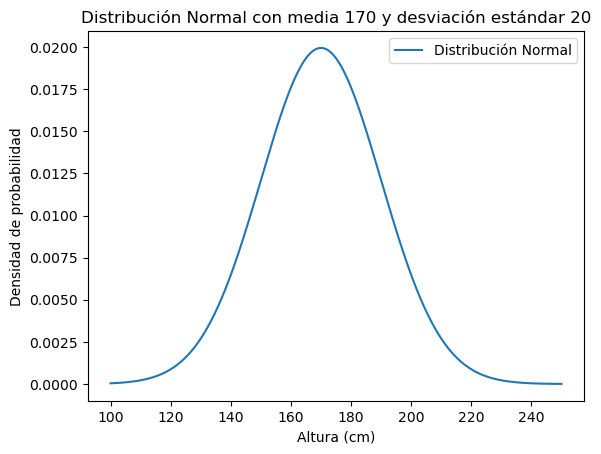

In [9]:
# Previa para mu
mu = stats.norm(loc=170, scale=20)
# Graficamos
x = np.linspace(100, 250, 1000)
plt.plot(x, mu.pdf(x), label="Distribución Normal")
plt.title("Distribución Normal con media 170 y desviación estándar 20")
plt.xlabel("Altura (cm)")
plt.ylabel("Densidad de probabilidad")
plt.legend()
plt.show()


Esto significa que el modelo asume que la **altura promedio** está, con alta probabilidad, entre $130$ cm y $210$ cm.

Ahora, la previa para $\sigma$ es plana; una distribución uniforme. Esta distribución restringe a $\sigma$ a estar entre cero, y $50$ con igual probabilidad:

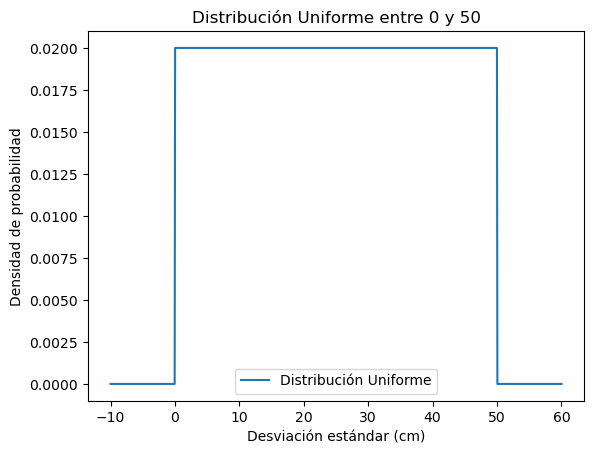

In [11]:
# Previa para sigma
sigma = stats.uniform(loc=0, scale=50)
# Graficamos
x = np.linspace(-10, 60, 1000)
plt.plot(x, sigma.pdf(x), label="Distribución Uniforme")
plt.title("Distribución Uniforme entre 0 y 50")
plt.xlabel("Desviación estándar (cm)")
plt.ylabel("Densidad de probabilidad")
plt.legend()
plt.show()

La desviación estándar obviamente debe de ser positiva, por lo que hace sentido que la cota inferior de la uniforme sea cero. 

¿Qué significa que esté acotada en $50$ cm por arriba? Significa que las alturas individuales se encontrarán en un rango de $100$ cm alrededor de la altura promedio.

Algo bastante importante, es que las previas hagan sentido, para lo cual una simulación **predictiva previa** es esencial.

In [12]:
# Librería Arviz: Análisis exploratorio de modelos Bayesianos
import arviz as az

In [13]:
# Simulación previa predictiva
N = 1000  # Número de muestras
# Muestreo de la previa de mu
mu_samples = mu.rvs(size=N)
# Muestreo de la previa de sigma
sigma_samples = sigma.rvs(size=N)
# Muestreo de la verosimilitud
height_samples = stats.norm(loc=mu_samples, scale=sigma_samples).rvs()

In [14]:
height_samples.shape

(1000,)

In [16]:
pd.DataFrame(height_samples).describe()

,0
count,1000.000000
mean,170.082802
std,37.003399
min,27.549366
25%,147.277124
50%,169.231803
75%,192.153392
max,347.630429


<Axes: >

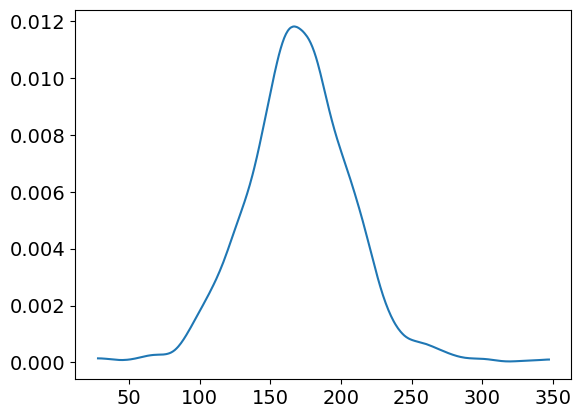

In [15]:
# az.plot_kde (Kernel Density Estimation)
az.plot_kde(height_samples)

In [17]:
az.hdi(height_samples, hdi_prob=0.95)

array([ 96.15144801, 237.26312572])

Notemos que la distribución previa para la altura no es una Gaussiana. Esto es correcto. Es una distribución de las probabilidades de las diferentes alturas antes de ver los datos.

La simulación predictiva previa es una herramienta poderosa para darnos cuenta que tan buenas son nuestras previas. A través de ella, nos podríamos dar cuenta que, por ejemplo, una previa $\mu \sim \text{Normal}(170, 100)$, no sería adecuada:

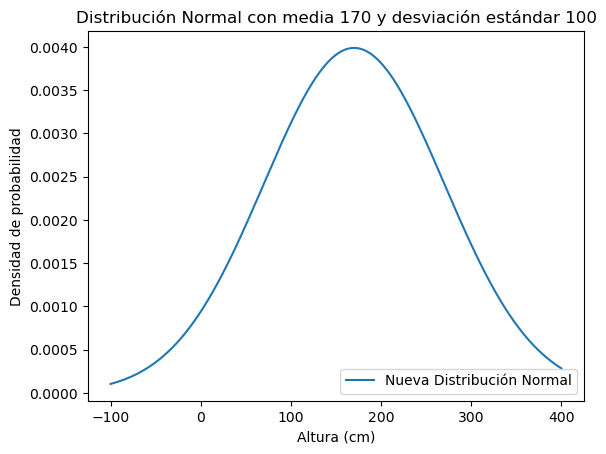

In [18]:
# mu ~ N(170, 100)
nueva_mu = stats.norm(loc=170, scale=100)
x = np.linspace(-100, 400, 1000)
plt.plot(x, nueva_mu.pdf(x), label="Nueva Distribución Normal")
plt.title("Distribución Normal con media 170 y desviación estándar 100")
plt.xlabel("Altura (cm)")
plt.ylabel("Densidad de probabilidad")
plt.legend()

In [20]:
# Simulación previa predictiva
N = 1000  # Número de muestras
# Muestreo de la previa de mu
mu_samples = nueva_mu.rvs(size=N)
# Muestreo de la previa de sigma
sigma_samples = sigma.rvs(size=N)
# Muestreo de la verosimilitud
height_samples = stats.norm(mu_samples, sigma_samples).rvs()

<Axes: >

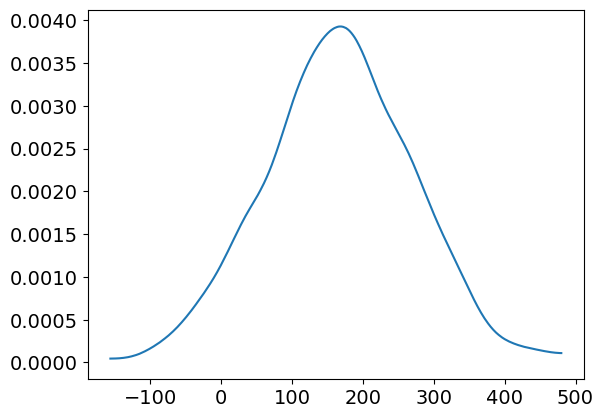

In [21]:
# az.plot_kde
az.plot_kde(height_samples)

In [22]:
# Porcentaje de registros con altura negativa
np.mean(height_samples < 0)

0.059

Con esta previa, estamos diciendo que el modelo antes de ver los datos, espera que $\sim 5$% de la población tenga una altura *negativa*.

¿Esto importa? Bueno, si tenemos una gran cantidad de datos, **NO**. Pero este no siempre será el caso. De cualquier forma, siempre convendrá tener previas que representen nuestro conocimiento lo mejor posible.

Nos quedaremos con nuestras previas originales.

**¿Cómo usamos la simulación Montecarlo para estimar las distribuciones posteriores?**

En el módulo pasado vimos que la simulación Montecarlo es una manera bastante efectiva de estimar distribuciones de probabilidad. 

La librería [pymc](https://www.pymc.io/welcome.html) automatiza la estimación de la distribución posterior haciendo uso de métodos MCMC, y con una sintaxis de python bastante sencilla, como veremos a continuación.

Recordamos el modelo:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu, \sigma) \\
\mu & \sim & \text{Normal}(170, 20) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

In [23]:
# Importamos pymc
import pymc as pm

In [36]:
# Definimos el modelo -- pm.Model()
heights = height_data_adults["height"].values
with pm.Model() as height_model:
    # mu ~ N(170, 20)
    mu = pm.Normal("mu", mu=170, sigma=20)
    # sigma ~ U(0, 50)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    # height ~ N(mu, sigma, observed=height)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=heights)

Hasta acá solo hemos definido el modelo. Si queremos muestrear la distribución posterior usando MCMC:

In [37]:
# pm.sample
with height_model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Veamos lo que contiene el objeto `idata` (inference data):

In [38]:
# Objeto idata
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

En el objeto `idata` está toda la información. Para visualizar gráficos de las distribuciones posteriores muestreadas, podemos hacer:

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

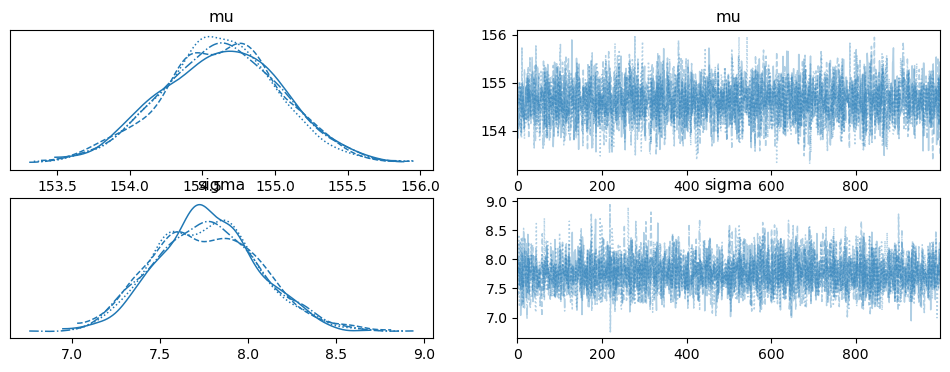

In [39]:
# az.plot_trace
az.plot_trace(idata)

O si lo queremos ver de forma numérica:

In [40]:
# az.summary
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.626,0.415,153.819,155.438,0.007,0.005,3889.0,2881.0,1.0
sigma,7.768,0.297,7.242,8.381,0.005,0.003,4134.0,2648.0,1.0


**Interpretación de las distribuciones posteriores de los parámetros**

In [41]:
# simulación posterior predictiva
with height_model:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [height]


In [42]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

<Axes: >

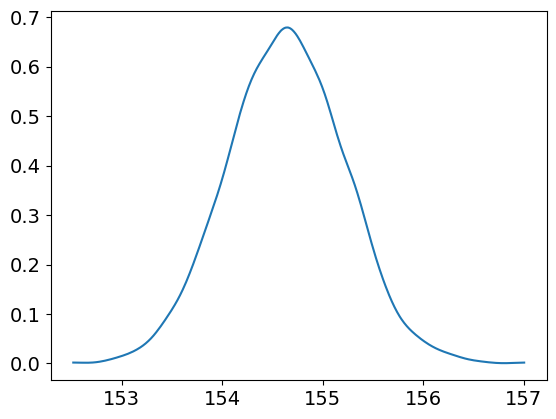

In [58]:
az.plot_kde(idata.posterior_predictive.mean(dim=("height_dim_2")).height.to_numpy().flatten())

c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\arviz\plots\ppcplot.py:264: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\arviz\plots\ppcplot.py:268: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='height / height'>

c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


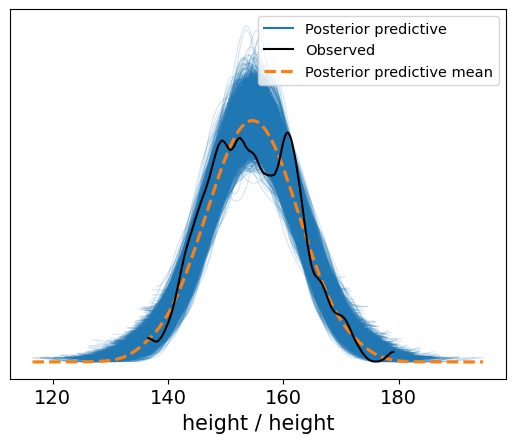

In [51]:
az.plot_ppc(idata)

# Anuncios

## 1. Repasar calendario restante


<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>